- добавить комментарии к ячейкам
- оформить все

Задание из видео Карпова [Разбор тестового задания на позицию junior аналитика данных](https://www.youtube.com/watch?v=3VWDh-gdiYg)

Описание данных:  
orders - таблица с информацией о заказах;  
order_id - уникальный идентификатор заказа;  
customer_id - уникальный идентификатор клиента;  
order_date - дата, когда заказ был создан;  
order_amount - cумма заказа;  
platform - платформа, через которую был сделан заказ (например, 'mobile', 'desktop');  
category - категория товара, который был заказан (например, 'smartphones', 'laptops').

1. Построй когортый анализ: выдели клиентов, совершивших первую покупку в течение определенного месяца (когортную дату) и вычисли размер каждой когорты.  
2. Рассчитай средний доход с клиента для каждой когорты за 10 дней с момента их первой покупки.  
3. Отобрази результаты по месяцам первых покупок, категориям товаров и платформам.  

Вывод должен содержать следующие поля:
- дата когорты;
- платформа;
- категория товара;
- размер когорты;
- средний доход с клиента.

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [91]:
sns.set(style='whitegrid', palette='pastel')

In [92]:
customer_ids = np.array([])
ids = []
for i in range(1, 1001):
    ids.append(i)
    customer_ids = np.append(customer_ids, np.random.choice(ids, (1, i // 50 + 1)))

In [93]:
customer_ids = customer_ids.astype(int)

In [94]:
# число заказов
N = customer_ids.size

In [95]:
order_dates = pd.date_range('2023-01-01', '2024-02-01', periods=N)

In [96]:
order_amounts = 111 + np.random.exponential(1, N) * 10000

In [97]:
platforms = np.random.choice(['mobile', 'desktop', 'shop'], N, p=[0.5, 0.3, 0.2])

In [98]:
categories = np.random.choice(['smartphones', 'laptops', 'watches'], N, p=[0.5, 0.3, 0.2])

In [99]:
df = pd.DataFrame({
    'order_id': range(1, N + 1), 
    'customer_id': customer_ids, 
    'order_date': order_dates, 
    'order_amount': order_amounts, 
    'platform': platforms, 
    'category': categories
})

In [100]:
df.dtypes

order_id                 int64
customer_id              int32
order_date      datetime64[ns]
order_amount           float64
platform                object
category                object
dtype: object

In [101]:
df.order_id = df.order_id.astype('int32')

In [102]:
df.platform = df.platform.astype('category')

In [103]:
df.category = df.category.astype('category')

In [104]:
df.dtypes

order_id                 int32
customer_id              int32
order_date      datetime64[ns]
order_amount           float64
platform              category
category              category
dtype: object

In [16]:
# df.to_pickle('data.pkl')

In [105]:
# времядату превращаем в дату
df['order_day'] = df.order_date.dt.to_period('D')

In [106]:
# месяц, в котором совершена первая покупка
df['first_order_month'] = (
    df
    .groupby('customer_id')['order_date']
    .transform('min')
    .dt.to_period('M')
)

In [107]:
# сколько дней прошло с первой покупки
df['day_from_start'] = (
    df['order_day'].astype(int) 
    - df.groupby('customer_id')['order_day'].transform('min').astype(int)
)
df['day_from_start'] = df['day_from_start'].astype('int32')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: casting period[D] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: casting period[D] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  after removing the cwd from sys.path.


In [108]:
# доход с покупателя в течение первых 10 дней
df['income_10_days'] = df[df.day_from_start < 10].groupby('customer_id').order_amount.transform(sum)

### 1
**Выдели клиентов, совершивших первую покупку в течение определенного месяца (когортную дату) и вычисли размер каждой когорты.**

In [20]:
# размер когорты каждого месяца
cohort_sizes = df.groupby('first_order_month').customer_id.nunique().reset_index()[:12]
cohort_sizes = cohort_sizes.rename(columns={'customer_id': 'cohort_size'})
cohort_sizes

,first_order_month,cohort_size
0,2023-01,220
1,2023-02,107
2,2023-03,92
3,2023-04,79
4,2023-05,72
5,2023-06,51
6,2023-07,61
7,2023-08,37
8,2023-09,59
9,2023-10,52


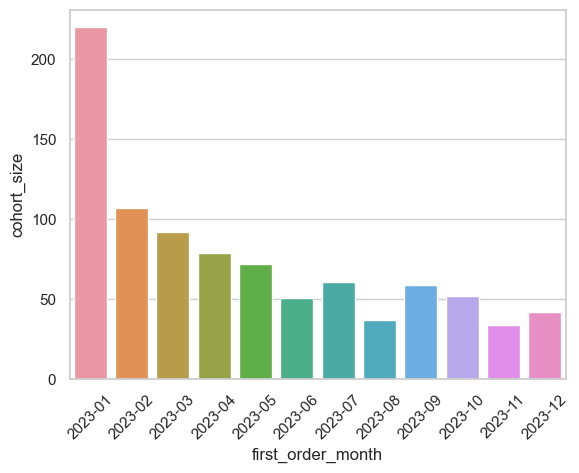

In [21]:
plt.xticks(rotation=45)
sns.barplot(cohort_sizes, y='cohort_size', x='first_order_month');

### 2
**Рассчитай средний доход с клиента для каждой когорты за 10 дней с момента их первой покупки.**

In [109]:
incomes_10_days = (
    df
    .groupby(['first_order_month', 'customer_id'])
    .income_10_days
    .min()
    .reset_index()
)
incomes_10_days.sample(5)

,first_order_month,customer_id,income_10_days
595,2023-06,612,36430.119302
618,2023-07,476,11492.946609
122,2023-01,125,49962.558564
230,2023-02,229,15364.069450
182,2023-01,194,249.557705


In [25]:
mean_user_incomes_10_days = (
    incomes_10_days
    .groupby('first_order_month')
    .agg(
        cohort_size=('customer_id', 'nunique'), 
        mean_user_income_10_days=('income_10_days', 'mean')
    )
    .astype(int)
    .reset_index()
    [:12]
)
mean_user_incomes_10_days

,first_order_month,cohort_size,mean_user_income_10_days
0,2023-01,220,24604
1,2023-02,107,17206
2,2023-03,92,16650
3,2023-04,79,12818
4,2023-05,72,13989
5,2023-06,51,15253
6,2023-07,61,14788
7,2023-08,37,16093
8,2023-09,59,14891
9,2023-10,52,12289


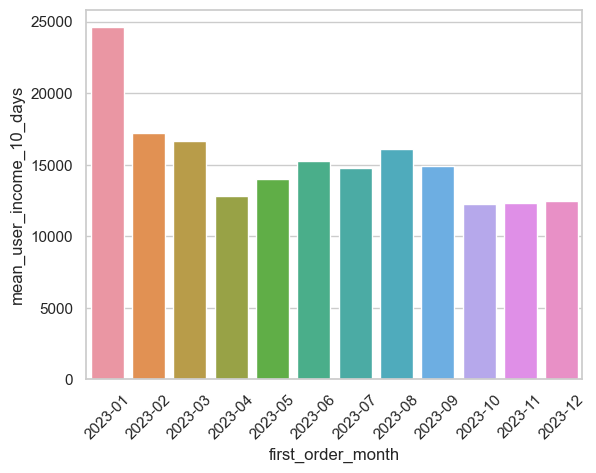

In [26]:
plt.xticks(rotation=45)
sns.barplot(mean_user_incomes_10_days, x='first_order_month', y='mean_user_income_10_days');
# sns.lmplot(mean_user_incomes_10_days, x='first_order_month', y='mean_user_income_10_days');

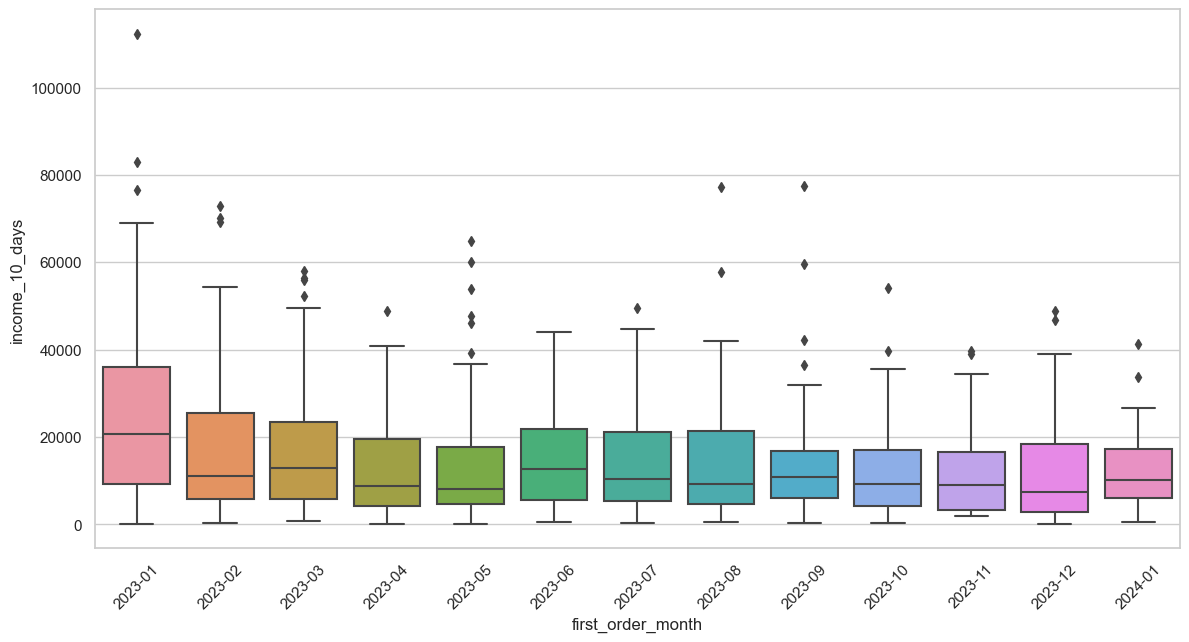

In [28]:
plt.figure(figsize=(14, 7))
plt.xticks(rotation=45)
sns.boxplot(incomes_10_days, y='income_10_days', x='first_order_month');

### 3
**Отобрази результаты по месяцам первых покупок, категориям товаров и платформам.**

In [117]:
incomes_10_days_by_platform = (
    df[df.day_from_start < 10]
    .groupby(['customer_id', 'platform'])
    .order_amount
    .sum()
    .reset_index()
)
incomes_10_days_by_platform.sample(5)

,customer_id,platform,order_amount
577,193,mobile,0.000000
2260,754,mobile,0.000000
2731,917,mobile,0.000000
2254,752,mobile,6854.723736
2589,866,desktop,17399.474126


In [118]:
incomes_10_days_by_platform[incomes_10_days_by_platform.customer_id == 12]

,customer_id,platform,order_amount
33,12,desktop,3176.032446
34,12,mobile,28741.979159
35,12,shop,42301.238873


In [89]:
incomes_10_days_by_platform[incomes_10_days_by_platform.customer_id == 102]

,customer_id,platform,order_amount
303,102,desktop,0.000000
304,102,mobile,5304.283319
305,102,shop,749.501255


In [47]:
(
    (
        df[df.day_from_start < 10]
        .pivot_table('order_amount', 'first_order_month', 'platform', aggfunc='sum')
    )
    / 
    (
        df[df.day_from_start < 10]
        .pivot_table('order_amount', 'first_order_month', 'platform', aggfunc='count')
    )
    .round()
    .astype(int)
    # .style.background_gradient()
)

platform,desktop,mobile,shop
first_order_month,,,
2023-01,9790.083208,8779.244955,10376.715534
2023-02,9730.493198,9498.564410,9022.276745
2023-03,9362.501885,9521.124462,10195.938953
2023-04,9400.371456,9433.921362,12467.799715
2023-05,9979.868532,9969.275789,9497.163661
2023-06,10079.637898,8226.379810,13390.717746
2023-07,12771.708503,10260.471368,10625.664133
2023-08,10597.885922,13445.122023,9893.503842
2023-09,8612.703742,10335.447008,12969.029378


In [121]:
(
    df[df.day_from_start < 10]
    .pivot_table('order_amount', 'first_order_month', 'category')[:12]
    .round()
    .astype(int)
    .style.background_gradient()
)

category,laptops,smartphones,watches
first_order_month,,,
2023-01,11180,9675,10757
2023-02,11243,9561,8347
2023-03,7704,10083,13117
2023-04,11289,10548,11789
2023-05,7000,7277,9781
2023-06,10400,10779,10376
2023-07,11299,11048,16148
2023-08,10067,10620,10912
2023-09,8047,9193,10355


In [35]:
df.sample(10)

,order_id,customer_id,order_date,order_amount,platform,category,order_day,first_order_month,day_from_start,income_10_days
3258,3259,511,2023-05-03 15:37:43.903412872,248.968819,shop,watches,2023-05-03,2023-05,0,6293.425195
9371,9372,486,2023-12-19 18:46:22.393763668,3496.569252,desktop,watches,2023-12-19,2023-05,232,NaN
7646,7647,307,2023-10-15 20:13:18.098678584,14701.468006,desktop,smartphones,2023-10-15,2023-03,225,NaN
5396,5397,47,2023-07-23 03:19:43.800741516,2862.313770,mobile,laptops,2023-07-23,2023-01,200,NaN
6760,6761,594,2023-09-12 11:42:49.179579808,11985.594338,desktop,laptops,2023-09-12,2023-06,86,NaN
4184,4185,218,2023-06-07 12:16:37.965586082,4828.848678,desktop,laptops,2023-06-07,2023-02,120,NaN
3172,3173,31,2023-04-30 09:55:37.845802834,187.985353,mobile,smartphones,2023-04-30,2023-01,117,NaN
489,490,108,2023-01-19 09:48:55.374084989,8069.734042,shop,watches,2023-01-19,2023-01,10,NaN
8199,8200,130,2023-11-05 15:51:41.701682672,9745.646411,mobile,smartphones,2023-11-05,2023-01,291,NaN
3762,3763,480,2023-05-22 14:59:48.706150776,19234.472170,mobile,smartphones,2023-05-22,2023-04,34,NaN


In [207]:
df.size

229950